In [2]:
# Download dependencies
%pip install opencv-python==4.7.0.68

  Obtaining dependency information for opencv-python==4.7.0.68 from https://files.pythonhosted.org/packages/be/12/6369d2b15422d4074d7aaf5332dcb0d590f8779020ba7135526ca6f49632/opencv_python-4.7.0.68-cp37-abi3-macosx_11_0_arm64.whl.metadata
Reason for being yanked: Deprecated, use 4.7.0.71
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 24.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.11.0.86
    Uninstalling opencv-python-4.11.0.86:
      Successfully uninstalled opencv-python-4.11.0.86

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install mediapipe

  Obtaining dependency information for mediapipe from https://files.pythonhosted.org/packages/f1/df/b1912b0d4e88c70a969258b201737c92ea268a90650c470ee842833a6690/mediapipe-0.10.21-cp312-cp312-macosx_11_0_universal2.whl.metadata
  Obtaining dependency information for jax from https://files.pythonhosted.org/packages/f9/e7/19b8cfc8963b2e10a01a4db7bb27ec5fa39ecd024bc62f8e2d1de5625a9d/jax-0.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for jaxlib from https://files.pythonhosted.org/packages/d9/9d/59b36e2f348e599d5812743f263ca54aa03be1a4c9dfc11504d19864b72d/jaxlib-0.8.1-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numpy<2 from https://files.pythonhosted.org/packages/75/5b/ca6c8bd14007e5ca171c7c03102d17b4f4e0ceb53957e8c44343a9546dcc/numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
  Obtaining dependency information for opencv-contrib-python from https:/

## Collecting Data for training the model

In [2]:
import os

import cv2

import string

In [3]:
# Collecting images for each of the signs

# Get the data directory to store all the images
data_dir = './data'

# Save all the letters in an array
alphabet = list(string.ascii_uppercase)

# If the directory doesn't exist, then make the new directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# We set the number of letters to be coded; we are coding for ASL
# so we are going to do 26 letters
number_of_letters = 26

# This is the number of frames that we want to capture for each letter class
dataset_size = 100

# Initialize the Video Capture object from cv2; 0 refers to which camera to be used
# for capturing the images. Here, we are using the laptop camera
capture = cv2.VideoCapture(0)

# We are going to loop through the number of letters
for j in range(number_of_letters):
    # Check if the directory for a specific letter is made, if not
    if not os.path.exists(os.path.join(data_dir, str(alphabet[j]))):
        # Make a directory under the data directory for the letter class
        os.makedirs(os.path.join(data_dir, str(alphabet[j])))

    # Print out to the console which letter is being collected
    print('Collecting data for letter {}'.format(alphabet[j]))

    # Initialize a variable for the while loop to check when we are done
    done = False

    # Continue the while loop is True; this is the wait screen;
    # The program will wait until you press Q to start the data capture
    while True:
        # This will 'read' the frames that are recieved from the capture object
        # ret is a boolean variable that returns True if the frame was successfully read, or False otherwise
        # frame is a numpy array of the image data of the frame captured
        ret, frame = capture.read()
        # Put text on the Capture Video object to signal to the user that they can start
        cv2.putText(frame, 'Ready? Press "Q" ! :', (100, 50), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1.3, 
                    (170, 238, 34), 3, cv2.LINE_AA)
        # Show the frame with the text 
        cv2.imshow('frame', frame)

        # The Capture Video object will wait 25 ms for the user to press q
        if cv2.waitKey(25) == ord('q'):
            # If q is pressed the while loop is broken and the Capture Video object
            # will start capturing data in the next step
            break
    
    # Initialize a variable to hold the count of the number letters that had collected data
    count = 0

    # Loop through the size of the dataset for each letter; this means that 100 frames are
    # collected per each letter
    while count < dataset_size:
        # Similar as before get the boolean value and image data of the frame
        ret, frame = capture.read()
        # Show the frame to the user
        cv2.imshow('frame', frame)
        # Wait for the user by 25ms
        cv2.waitKey(25)
        # Write in the directory that was created for the letter
        cv2.imwrite(os.path.join(data_dir, str(alphabet[j]), '{}.jpg'.format(count)), frame)
        # Increase the counter by 1
        count += 1

# Release the Capture Video object
capture.release()
# Destroy all the windows
cv2.destroyAllWindows()

## Dimensionality Reduction

We need to reduce the amount of data that is being processed in the model. The original images have a lot of data 256 by 256 pixels and we want to convert that to an array of ~20-30 points. 

In [3]:
import mediapipe as mp
import matplotlib.pyplot as plt

I0000 00:00:1764380475.849772 2398181 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1764380475.896629 2548263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764380475.914629 2548261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/var/folders/6r/nx6jkx254q31jrf83vmvvwhw0000gn/T/ipykernel_34340/2405461911.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


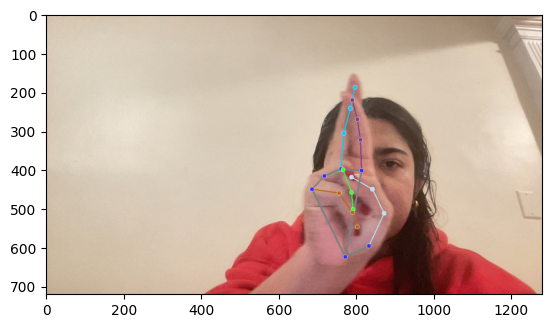

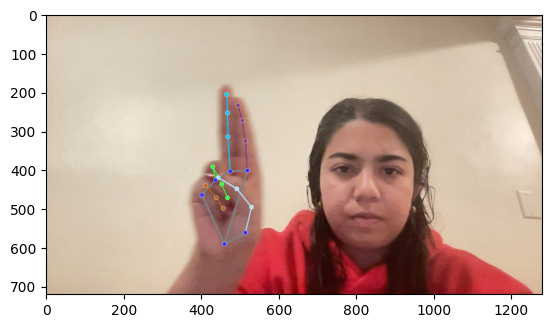

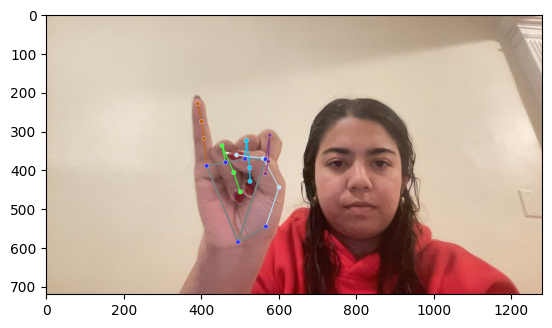

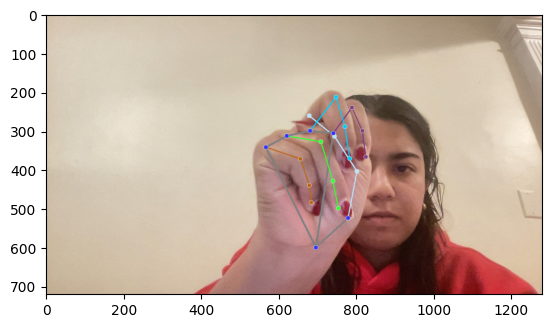

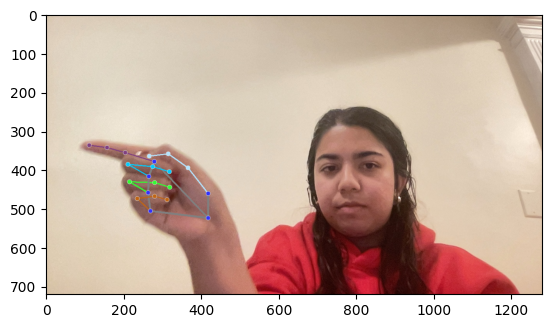

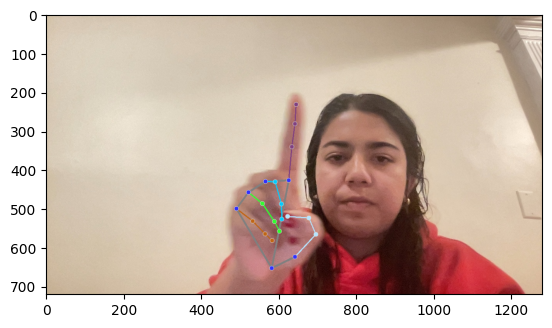

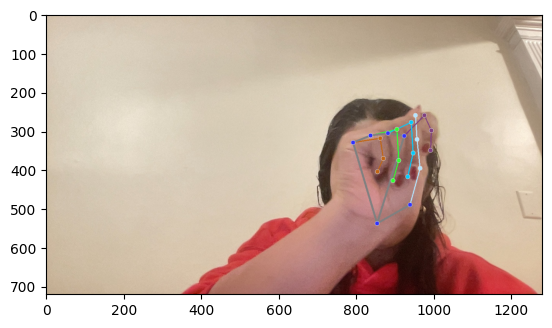

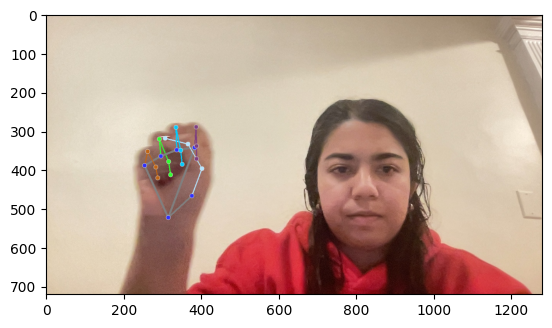

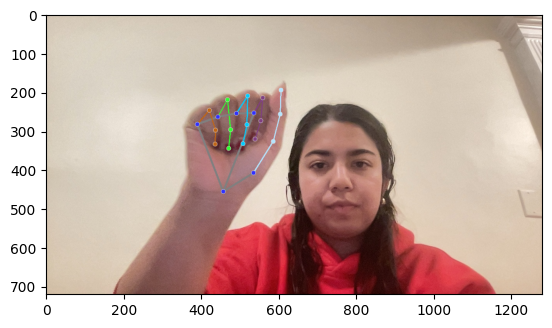

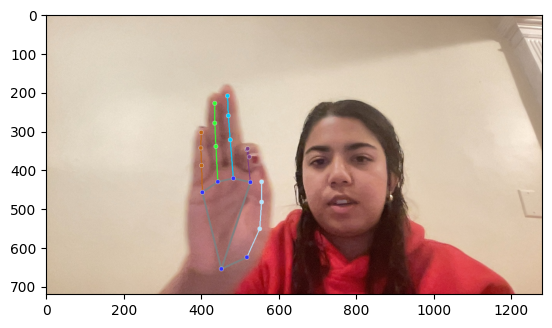

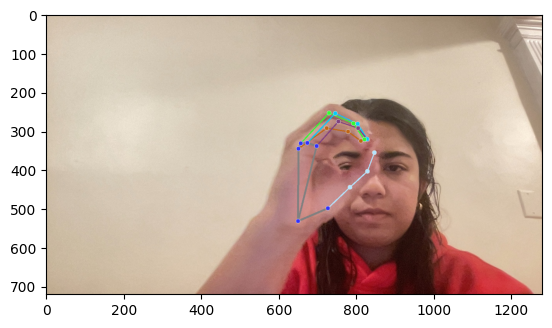

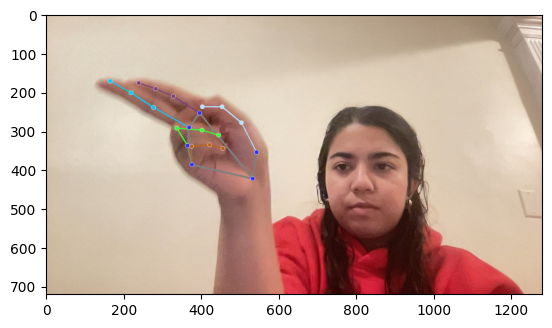

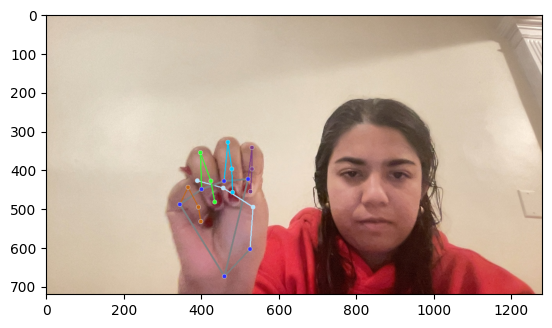

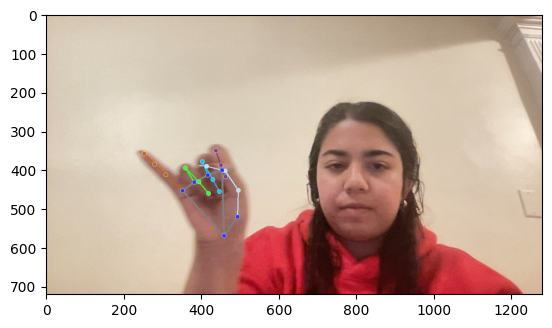

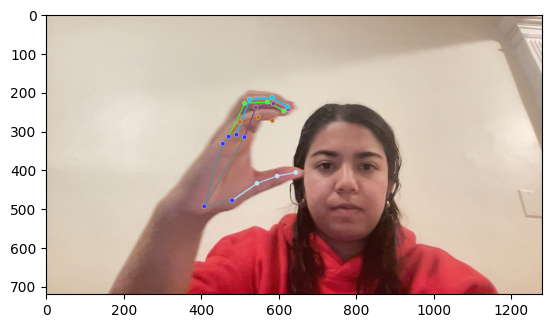

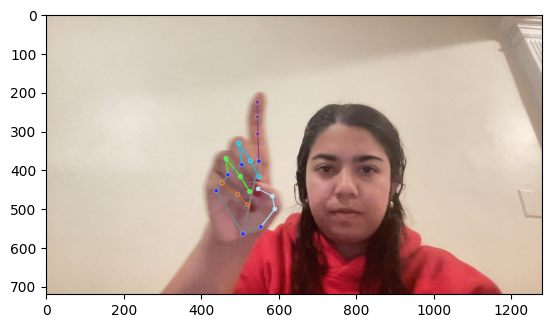

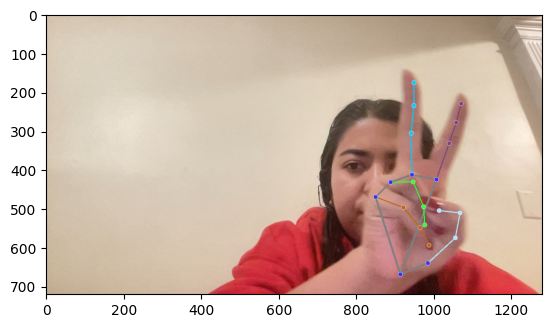

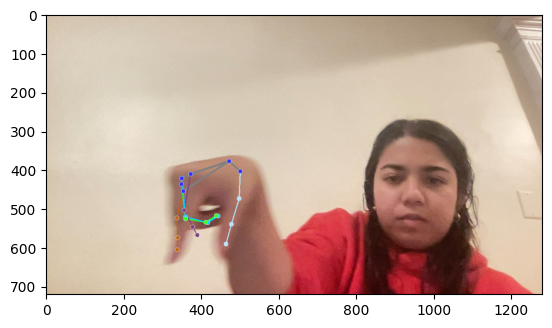

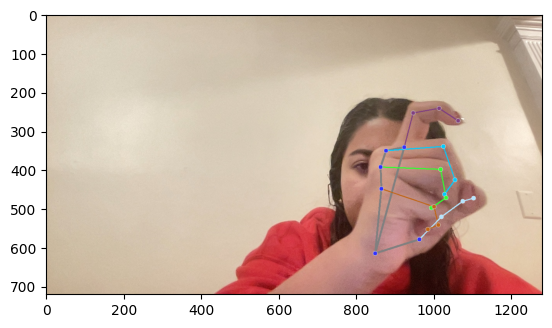

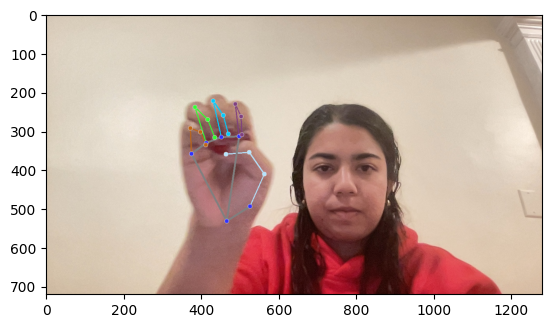

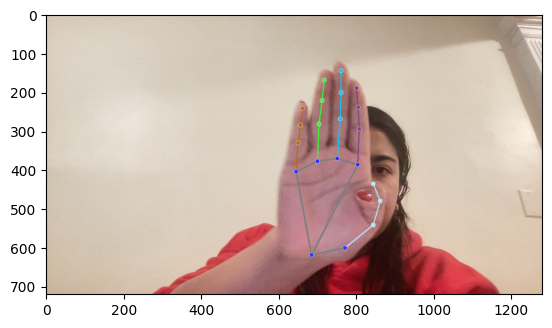

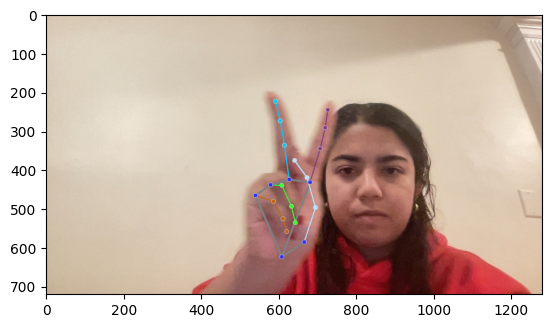

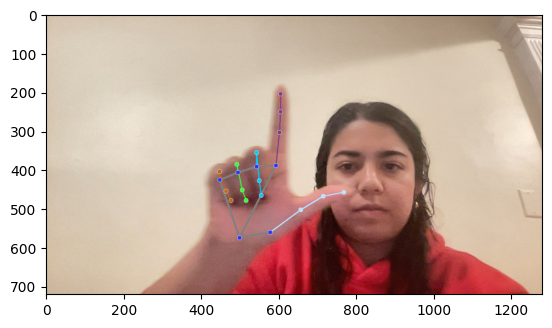

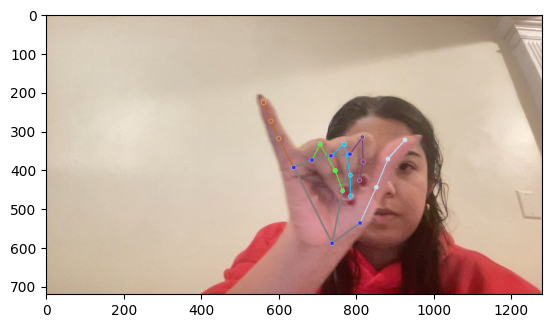

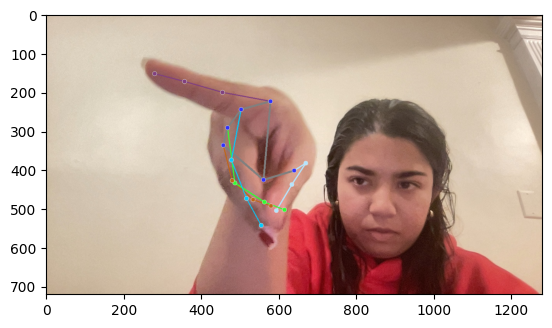

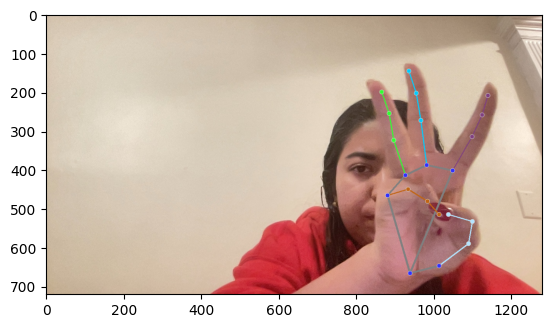

In [36]:
# This is the main directory where all the directories are stored 
data_dir = './data'

# Create array for saving the data created by the hand dector and labels
data = []
labels = []

# Define the objects used to landmark the hands in the images
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Define the hand detector
hands = mp_hands.Hands(static_image_mode = True, min_detection_confidence=0.3)

# Loop through all the directories in the main directory
for dir_ in os.listdir(data_dir):
    # We are going to use a count variable to print only 1 image from each directory
    count = 1
    # Loop through all the images in that sub directory
    for img_path in os.listdir(os.path.join(data_dir, dir_)):
        # Empty array to hold the x and y coordinates
        data_aux = []

        x_ = []
        y_ = []

        # Get the specific image in the subdirectory
        img = cv2.imread(os.path.join(data_dir, dir_, img_path))
        # Convert the image to rgb
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        # Use the hand detection object on the image that is read-in
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            # Loop through all the landmarks made for each image from the
            # hand detection object
            for hand_landmarks in results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                # Draw the landmarks on the images (you will see them 
                # printed out on the image)
                mp_drawing.draw_landmarks(
                    img_rgb,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )
                # Save the X and Y coordinate of each landmark in the array
                # created

                # Loop through all the coordinates for each landmark
                for i in range(len(hand_landmarks.landmark)):
                
                    # Get the x-coordinate
                    x = hand_landmarks.landmark[i].x
                    # Get y-coordinate
                    y = hand_landmarks.landmark[i].y

                    # Append the x and y coordinates for the specific landmark
                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))    

            # Append the x and y coordinates as an array in the data array
            data.append(data_aux)
            # Append the label to the label array from the name of the directory
            labels.append(dir_)

        # Plot the images to see how they look
        if count > 0:
            plt.figure()
            plt.imshow(img_rgb)
            count -= 1

plt.show()

In [40]:
# Check the length of each sample
lengths = [len(d) for d in data]
print(f"Unique lengths found: {set(lengths)}")
print(f"Most common length: {max(set(lengths), key=lengths.count)}")

# Keep only samples with the most common length (usually 42 for one hand)
target_length = max(set(lengths), key=lengths.count)
filtered_data = []
filtered_labels = []

for d, l in zip(data, labels):
    if len(d) == target_length:
        filtered_data.append(d)
        filtered_labels.append(l)

print(f"Original samples: {len(data)}, Filtered samples: {len(filtered_data)}")

Unique lengths found: {42, 84}
Most common length: 42
Original samples: 2597, Filtered samples: 2596


In [10]:
import pickle

In [41]:
# Save the processed image data in a pickle file
f = open('data.pickle', 'wb')
pickle.dump({'data': filtered_data, 'labels': filtered_labels}, f)
f.close()